# КУРСОВАЯ РАБОТА
# "Распределение Лапласа при исследовании колебаний фондовых индексов"
# Приложение 2. Программный код
## Автор: Степенко З. В.
## Группа: ПМ2-3
## весна 2019 г.

## Подключение необходимых библиотек и модулей

In [228]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [229]:
import pandas as pd

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [231]:
import datetime
import scipy.stats as stats

In [232]:
from scipy.stats import laplace
from scipy.optimize import fsolve

In [233]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

In [234]:
import scipy
import math

In [600]:
import xlsxwriter

In [235]:
import warnings
warnings.filterwarnings("ignore")

### Cравнение плотности распределения Лапласа с плотностями других распределений

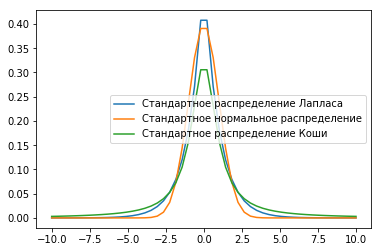

In [236]:
x = np.linspace(-10,10)
plt.plot(x,stats.laplace.pdf(x),label='Стандартное распределение Лапласа')
plt.plot(x,stats.norm.pdf(x),label='Стандартное нормальное распределение')
plt.plot(x,stats.cauchy.pdf(x),label='Стандартное распределение Коши')
plt.legend(loc='right')

### Пользовательские функции для обработки данных по колебаниям мировых фондовых индексов

#### Преобразование таблиц, содержащих информацию об исследуемых показателях, для дальнейшей работы

In [368]:
def processing_data(CSV):
    # удаление неиспользуемых столбцов
    CSV = CSV.drop('Volume', axis=1) 
    CSV = CSV.drop('Adj Close', axis=1)
    CSV = CSV.drop('High', axis=1)
    CSV = CSV.drop('Low', axis=1)
    CSV = CSV.drop('Open', axis=1)
    
    #формирование лаг-пропорций и удаление первых строк, содержащих NULL-значение в столбце 'LagRatio'
    CSV['CloseMove'] = CSV['Close'].shift(1)
    CSV['LagRatio'] = CSV['Close']/CSV['CloseMove']
    CSV = CSV[CSV['LagRatio'].notnull()]
    
    #печать данных по выборке
    print('Объем выборки:', len(CSV['Close']))
    print('Максимальное значение выборки: ', max(CSV['Close']))
    print('Минимальное значение выборки: ', min(CSV['Close']))
    return CSV

#### Работа с датами для корректной визуализации значений показателей

In [369]:
def date_plot_label_format(CSV):
    date_INDEX = pd.to_datetime(pd.Series(CSV['Date']).values).to_pydatetime()
    datemin = np.datetime64(date_INDEX[0], 'Y')
    datemax = np.datetime64(date_INDEX[-1], 'Y') + np.timedelta64(1, 'Y')
    return datemin, datemax, date_INDEX

In [370]:
years = mdates.YearLocator()   
months = mdates.MonthLocator() 
years_final = mdates.DateFormatter('%Y')

#### Визуализация динамики суточных значений индекса по годам

In [389]:
def series_standart_plot(CSV):
    #вызов функции для обработки столбца с датами
    d = date_plot_label_format(CSV)
    datemin = d[0]
    datemax = d[1]
    date_INDEX = d[2]
    
    #построение графика значений индекса по дням
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(date_INDEX, CSV['Close'], color=CSV['Plot Color'][1])
    ax.plot
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_final)
    ax.xaxis.set_minor_locator(months)
    ax.set_xlim(datemin, datemax)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    label = 'Динамика индекса ' + CSV['Index Name'][1] + ' в 2014-2019 гг.'
    ax.set_title(label,fontsize=14)
    ax.set_xlabel('Период',fontsize=12)
    ax.set_ylabel('Значение индекса',fontsize=12)
    ax.grid(True)
    fig.autofmt_xdate()
    filename = 'Динамика индекса ' + str(CSV['Index Name'][1]) + '.png'
    fig.savefig(filename)

#### Построение графика лагов (отношений) "цен закрытия" по данным о конкретном индексе

In [393]:
def lag_ratio_plot(CSV):
    plt.grid(True)
    csv_lag1 = CSV['LagRatio']
    plt.plot(csv_lag1, color = CSV['Plot Color'][1])
    label = 'Суточные колебания индекса ' + CSV['Index Name'][1] + ' в 2014-2019 гг.'
    plt.title(label, fontsize=14)
    plt.xlabel('Номер измеренного значения',fontsize=12)
    plt.ylabel('Размах колебания',fontsize=12)
    plt.grid(True)
    filename = 'Суточные колебания индекса ' + str(CSV['Index Name'][1]) + '.png'
    plt.savefig(filename)

#### Анализ закона распределений вероятностей колебаний мировых фондовых индексов

In [242]:
def goodness_of_fit_testing(CSV):
    #загрузка столбца 'LagRatio' с выборочными данными
    obsData = CSV['LagRatio'][2::]
    
    #список тестовых распределений (может варьироваться)
    distrib = ['beta', 
                  'cauchy',
                  'chi',
                  'chi2',
                  'gamma',
                  'gengamma',
                  'genlogistic',
                  'lognorm',
                  'norm',
                  'laplace',
                  'johnsonsb',
                  'loglaplace',
                  'logistic',
                  't',
                  'weibull_min', 
                  'weibull_max']
        
    chi = [] #список статистик хи-квадрат для тестовых распределений
    pV = [] 
    
    PV_MM = scipy.stats.kstest(obsData, 'laplace', args = (CSV['am'][1], CSV['bm'][1]))[1]
    PV_MM = np.around(PV_MM, 5)
    
    perc_bin = np.linspace(0,100,50)
    perc_cut = np.percentile(obsData, perc_bin)
    observeF, bins = (np.histogram(obsData, bins=perc_cut))
    sum_observeF = np.cumsum(observeF)
        
    for d in distrib:
        dist = getattr(scipy.stats, d)
        est = dist.fit(obsData)   
        p_v = scipy.stats.kstest(obsData, d, args=est)[1]
        p_v = np.around(p_v, 5)
        pV.append(p_v)
        
        #функция cdf с подходящими по методу максимального правдоподобия параметрами
        fit_CDF = dist.cdf(perc_cut, *est[:-2], loc=est[-2], scale=est[-1])
        expectF = []
           
        for bin in range(len(perc_bin)-1):
            exp_CDF = fit_CDF[bin+1] - fit_CDF[bin]
            expectF.append(exp_CDF)
                
        expectF = np.array(expectF) * len(obsData)
        sum_expectF = np.cumsum(expectF)
        check = sum(((sum_expectF- sum_observeF) ** 2) / sum_observeF)
        chi.append(check)
            
    BestFit = pd.DataFrame()
    BestFit['Распределение'] = distrib
    BestFit['Хи-квадрат'] = chi
    BestFit['P-значение(MLE)'] = pV
    BestFit.sort_values(['Хи-квадрат'], inplace=True)
    
    outCSV = str(CSV['Index Name'][1]) + '.csv'
    BestFit.to_csv(outCSV)
        
    print ('\nНаиболее подходящие распределения для колебаний индекса',CSV['Index Name'][1],':')
    print ('__________________________________________________')
    print (BestFit)
    print ('___________________________________________________')
    print('P-значение для распределения Лапласа (MM):', PV_MM)

#### Поиск подходящий параметров распределения Лапласа для исходных данных методом максимального правдоподобия

In [243]:
def MLE_laplace_estimators(CSV):
    data = CSV['LagRatio'][1::]
    estimators = laplace.fit(data)
    CSV['a'] = estimators[0]
    CSV['b'] = estimators[1]
    return CSV

#### Поиск подходящих параметров распределения Лапласа для исходных данных методом моментов

In [244]:
def MM_laplace_estimators(CSV):
    data = CSV['LagRatio'][1::]
    n = len(CSV['LagRatio'][1::])
    CSV['am'] = np.mean(data)
    sum = 0
    for i in range(1,n):
        sum = sum + (CSV['LagRatio'][i]-CSV['am'][1])**2
    CSV['bm'] = math.sqrt(sum/(2*n))
    return CSV

#### Построение гистограммы частот распределения колебаний значений индекса и наложение функции плотности распределения Лапласа с оценочными параметрами а и b

In [491]:
def fluctuating_index_distribution(CSV):
    max_index_LagRatio = np.nanmax(CSV['LagRatio'])
    min_index_LagRatio = np.nanmin(CSV['LagRatio'])
    plt.hist(CSV['LagRatio'],bins=50,density=True,color=CSV['Plot Color'][1], label='Частоты изменений значений')
    x = np.linspace(round(min_index_LagRatio,2),round(max_index_LagRatio,2))
    y = stats.laplace.pdf(x,loc=CSV['a'][1],scale=CSV['b'][1])
    y1 = stats.laplace.pdf(x,loc=CSV['am'][1],scale=CSV['bm'][1])
    plot_title = 'Распред. колебаний индекса ' + CSV['Index Name'][1] + ' в 2014-2019 гг.'
    plt.title(plot_title,fontsize=14)
    plt.xlabel('Размах колебания',fontsize=12)
    plt.ylabel('Частота колебания',fontsize=12)
    plt.grid(True)
    plt.plot(x,y,color='red', label='Распределение Лапласа с подходящими по MLE параметрами')
    plt.plot(x,y1,color='lime', label='Распределение Лапласа с подходящими по MM параметрами')
    plt.legend(loc='center')
    s1 = 'Оценка по методу максимального правдоподобия: a = ' + str(round(CSV['a'][1],6)) + '; b = ' + str(round(CSV['b'][1],6))
    print(s1)
    s2 = 'Оценка по методу моментов: a = ' + str(round(CSV['am'][1],6)) + '; b = ' + str(round(CSV['bm'][1],6))
    print(s2)
    txt_name = 'Оценки параметров распределения Лапласа для колебаний индекса ' + CSV['Index Name'][1] + '.txt'
    file = open(txt_name,'w') 
    file.write(s1+'\n') 
    file.write(s2)
    file.close()
    filename = 'Гистограмма лаг-пропорций индекса ' + str(CSV['Index Name'][1]) + '.png'
    plt.savefig(filename)

### Построение графиков, сравнивающих значения эмпирических и теоретических квантилей распределения колебаний фондовых индексов (QQ-plots)

#### Для распределения Лапласа

In [408]:
def QQ_plot(CSV):
    fig = sm.qqplot(CSV['LagRatio'], stats.laplace, fit=True,line='45', color=CSV['Plot Color'][1])
    
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Эмпирические квантили')
    title = 'Q-Q-график для колебаний индекса ' + CSV['Index Name'][1] + ' по Лапласу'
    plt.title(title)
    plt.show()
    filename = 'QQ plot ' + CSV['Index Name'][1] + ' (Лаплас)' + '.png'
    fig.savefig(filename)

#### Для нормального распределения

In [409]:
def QQ_plot_N(CSV):
    fig = sm.qqplot(CSV['LagRatio'], stats.norm, fit=True,line='45', color=CSV['Plot Color'][1])
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Эмпирические квантили')
    title = 'Q-Q-график для колебаний индекса ' + CSV['Index Name'][1] + ' по Гауссу'
    plt.title(title)
    plt.show()
    filename = 'QQ plot ' + CSV['Index Name'][1] + ' (Гаусс)' + '.png'
    fig.savefig(filename)

### Построение графиков, сравнивающих эмпирическую и теоретическую функции распределения колебаний фондовых индексов (PP-plots)

#### Для распределения Лапласа

In [443]:
 def PP_plot(CSV):
    data = list(CSV['LagRatio'])
    data.sort()
    
    lapl = getattr(scipy.stats, 'laplace')
    lapl_param = lapl.fit(data)
    laplace_sample = lapl.rvs(*lapl_param[0:-2],loc=lapl_param[-2], scale=lapl_param[-1],size = len(data))
    laplace_sample.sort()
    lapl_bins = np.percentile(laplace_sample,range(0,101))
    data_counts, lapl_bins = np.histogram(data,lapl_bins)
    laplace_counts, lapl_bins = np.histogram(laplace_sample,lapl_bins)
    cum_data = np.cumsum(data_counts)
    cum_laplace = np.cumsum(laplace_counts)
    cum_data = cum_data / max(cum_data)
    cum_laplace = cum_laplace / max(cum_laplace)
    
    max_fl = (max(max(cum_laplace),max(cum_data)))
    min_fl = (min(min(cum_laplace),min(cum_data)))
    plt.plot(cum_laplace,cum_data,'o', color=CSV['Plot Color'][1])
    plt.plot([min_fl,max_fl],[min_fl,max_fl],color='red')
    plt.xlabel('Теоретические вероятности')
    plt.ylabel('Эмпирические вероятности')
    title = 'P-P-график колебаний индекса ' + CSV['Index Name'][1] + ' по Лапласу'
    plt.title(title)
    filename = 'PP plot ' + CSV['Index Name'][1] + ' (Лаплас)' + '.png'
    plt.savefig(filename)

#### Для нормального распределения

In [445]:
def PP_plot_N(CSV):
    data = list(CSV['LagRatio'])
    data.sort()
    
    norm = getattr(scipy.stats, 'norm')
    norm_param = norm.fit(data)
    norm_sample = norm.rvs(*norm_param[0:-2],loc=norm_param[-2], scale=norm_param[-1],size = len(data))
    norm_sample.sort()
    norm_bins = np.percentile(norm_sample,range(0,101))
    data_counts, norm_bins = np.histogram(data,norm_bins)
    normal_counts, norm_bins = np.histogram(norm_sample,norm_bins)
    cum_data = np.cumsum(data_counts)
    cum_normal = np.cumsum(normal_counts)
    cum_data = cum_data / max(cum_data)
    cum_normal = cum_normal / max(cum_normal)
    
    max_fl = (max(max(cum_normal),max(cum_data)))
    min_fl = (min(min(cum_normal),min(cum_data)))
    plt.plot(cum_normal,cum_data,'o', color=CSV['Plot Color'][1])
    plt.plot([min_fl,max_fl],[min_fl,max_fl],color='red')
    plt.xlabel('Теоретические вероятности')
    plt.ylabel('Эмпирические вероятности')
    title = 'P-P-график колебаний индекса ' + CSV['Index Name'][1] + ' по Гауссу'
    plt.title(title)
    filename = 'PP plot ' + CSV['Index Name'][1] + ' (Гаусс)' + '.png'
    plt.savefig(filename)

### Создание таблицы квантилей уровня от 0.1 до 0.99 для колебаний индекса

In [539]:
def quantile_table(CSV):
    k = list(np.around(arange(0.01,1,0.01),2))
    q = []
    for i in range(len(k)):
        q.append(round(CSV['LagRatio'].quantile(k[i]),6))
    Quant = pd.DataFrame()
    Quant['Порядок alpha'] = k
    Quant['Значение квантиля'] = q
    outCSV = 'Квантили 99 уровней, индекс '+ str(CSV['Index Name'][1]) + '.csv'
    Quant.to_csv(outCSV)
    return Quant

### Вычисление вероятностей роста и падения суточных значений индекса

In [611]:
def loss_gain_probs(CSV):
    a = CSV['a'][1]
    b = CSV['b'][1]
    parameters = (a,b)
    max_gain = laplace.ppf(0.9999,*parameters)
    min_gain = laplace.ppf(0.0001,*parameters)
    if (max_gain > 1):
        print('Следующий скачок вверх <= ',round((max_gain-1)*100,2),'%')
    if (min_gain <= 1):
        print('Следующий скачок вниз >=',round((1-min_gain)*100,2),'%')
    level = list(np.around(arange(0.005,0.05,0.005),3))
    gain_prob = []
    loss_prob = []
    for i in range(len(level)):
        gain_prob.append(laplace.cdf(1+level[i],*parameters))
        loss_prob.append(laplace.cdf(1-level[i],*parameters))
        level[i] = 100*level[i]
    Prob = pd.DataFrame()
    Prob[' Изменение x, %'] = level
    Prob['Вероятность падения на x %'] = loss_prob
    Prob['Вероятность роста на x %'] = gain_prob
    nameTab = 'Вероятности для индекса ' + CSV['Index Name'][1] + '.xlsx'
    nameSheet = 'Вер-ти для ' + CSV['Index Name'][1]
    Prob.to_excel(nameTab, sheet_name = nameSheet, encoding = 'utf8')
    return Prob

## Исследование колебаний мировых фондовых индексов (на реальных данных)

### 1. Промышленный индекс Доу-Джонса (DJIA)

#### Демонстрация структуры необработанных данных на примере индекса Доу-Джонса

In [250]:
DJIA_raw_example = pd.read_csv('DJIA_raw.csv')

In [251]:
DJIA_raw_example

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,26510.769531,26553.050781,26458.609375,26511.050781,26511.050781,232570000
1,2019-04-23,26513.830078,26695.960938,26503.560547,26656.390625,26656.390625,311690000
2,2019-04-24,26652.560547,26680.580078,26582.859375,26597.050781,26597.050781,283370000
3,2019-04-25,26426.369141,26536.480469,26310.279297,26462.080078,26462.080078,296730000
4,2019-04-26,26454.619141,26543.560547,26392.550781,26543.330078,26543.330078,317290000
5,2019-04-29,26559.869141,26602.539063,26520.750000,26554.390625,26554.390625,279450000
6,2019-04-30,26594.560547,26614.039063,26419.470703,26592.910156,26592.910156,340320000
7,2019-05-01,26639.060547,26689.390625,26426.380859,26430.140625,26430.140625,303850000
8,2019-05-02,26407.150391,26454.689453,26180.359375,26307.789063,26307.789063,287610000
9,2019-05-03,26379.140625,26534.960938,26370.089844,26504.949219,26504.949219,248900000


In [652]:
DJIA = processing_data(pd.read_csv('Stepenko_DJIA.csv'))
DJIA

Объем выборки: 1339
Максимальное значение выборки:  26828.390625
Минимальное значение выборки:  15372.799805


,Date,Close,CloseMove,LagRatio
1,2014-01-02,16441.349609,16576.660156,0.991837
2,2014-01-03,16469.990234,16441.349609,1.001742
3,2014-01-06,16425.099609,16469.990234,0.997274
4,2014-01-07,16530.939453,16425.099609,1.006444
5,2014-01-08,16462.740234,16530.939453,0.995874
6,2014-01-09,16444.759766,16462.740234,0.998908
7,2014-01-10,16437.050781,16444.759766,0.999531
8,2014-01-13,16257.940430,16437.050781,0.989103
9,2014-01-14,16373.860352,16257.940430,1.007130
10,2014-01-15,16481.939453,16373.860352,1.006601


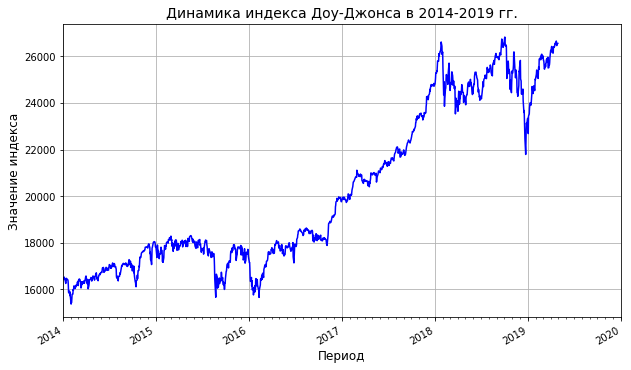

In [388]:
series_standart_plot(DJIA)

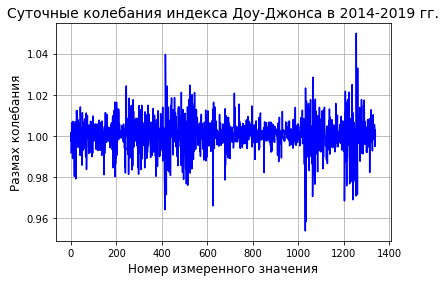

In [394]:
lag_ratio_plot(DJIA)

In [257]:
DJIA = MLE_laplace_estimators(DJIA)

In [258]:
DJIA = MM_laplace_estimators(DJIA)

In [625]:
goodness_of_fit_testing(DJIA)


Наиболее подходящие распределения для колебаний индекса Доу-Джонса :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
9        laplace     26.164819          0.19908
11    loglaplace     26.790230          0.20506
13             t     47.454123          0.31015
1         cauchy    118.594194          0.00167
6    genlogistic    145.284867          0.00026
12      logistic    167.469026          0.00021
10     johnsonsb    521.378092          0.00000
5       gengamma    522.673129          0.00000
0           beta    536.583074          0.00000
8           norm    585.177614          0.00000
7        lognorm    588.482385          0.00000
2            chi    691.918354          0.00000
14   weibull_min    810.090081          0.00000
3           chi2    914.287839          0.00000
15   weibull_max   1259.120026          0.00000
4          gamma  20794.342695          0.00000
___________________________________________________
P-значение 

Оценка по методу максимального правдоподобия: a = 1.000556; b = 0.005776
Оценка по методу моментов: a = 1.000393; b = 0.005891


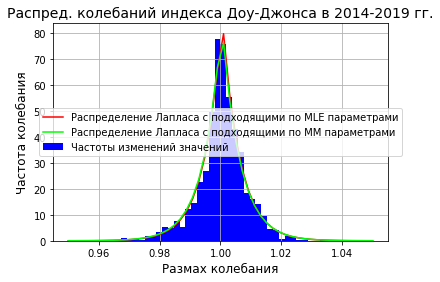

In [624]:
fluctuating_index_distribution(DJIA)

In [540]:
quantile_table(DJIA)

,Порядок alpha,Значение квантиля
0,0.01,0.976323
1,0.02,0.980031
2,0.03,0.982274
3,0.04,0.984307
4,0.05,0.985632
5,0.06,0.987095
6,0.07,0.988631
7,0.08,0.989550
8,0.09,0.990180
9,0.10,0.990868


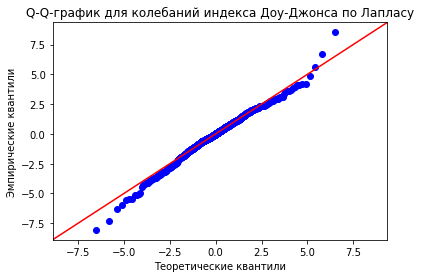

In [407]:
QQ_plot(DJIA)

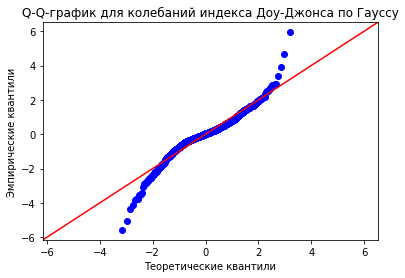

In [410]:
QQ_plot_N(DJIA)

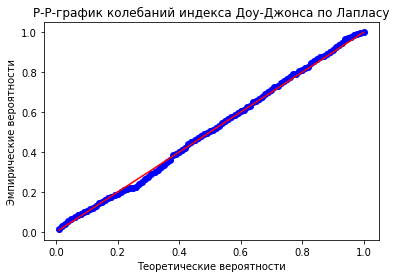

In [444]:
PP_plot(DJIA)

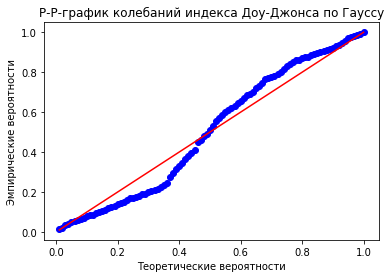

In [446]:
PP_plot_N(DJIA)

In [602]:
loss_gain_probs(DJIA)

Следующий скачок вверх <=  4.98 %
Следующий скачок вниз >= 4.86 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.191109,0.768355
1,1.0,0.080420,0.902522
2,1.5,0.033841,0.958981
3,2.0,0.014241,0.982739
4,2.5,0.005993,0.992736
5,3.0,0.002522,0.996943
6,3.5,0.001061,0.998714
7,4.0,0.000447,0.999459
8,4.5,0.000188,0.999772


### 2. Индекс NASDAQ Composite

In [265]:
NASDAQ = processing_data(pd.read_csv('Stepenko_NASDAQ.csv'))

Объем выборки: 1340
Максимальное значение выборки:  8161.850098000001
Минимальное значение выборки:  3996.959961


In [266]:
NASDAQ

,Date,Close,CloseMove,LagRatio
1,2014-01-02,4143.069824,4176.589844,0.991974
2,2014-01-03,4131.910156,4143.069824,0.997306
3,2014-01-06,4113.680176,4131.910156,0.995588
4,2014-01-07,4153.180176,4113.680176,1.009602
5,2014-01-08,4165.609863,4153.180176,1.002993
6,2014-01-09,4156.189941,4165.609863,0.997739
7,2014-01-10,4174.669922,4156.189941,1.004446
8,2014-01-13,4113.299805,4174.669922,0.985299
9,2014-01-14,4183.020020,4113.299805,1.016950
10,2014-01-15,4214.879883,4183.020020,1.007616


In [267]:
NASDAQ['Index Name'] = 'NASDAQ Composite'
NASDAQ['Plot Color'] = 'green'

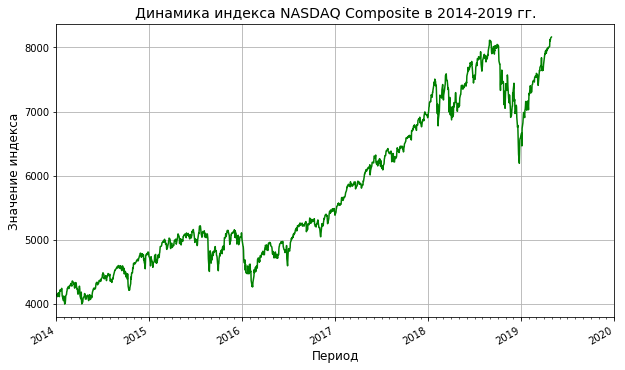

In [415]:
series_standart_plot(NASDAQ)

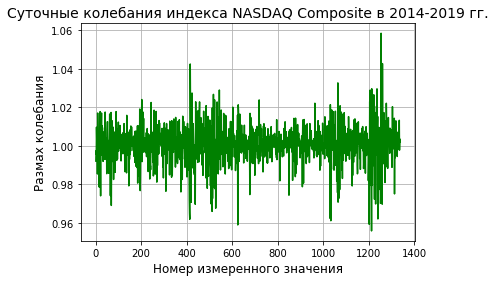

In [416]:
lag_ratio_plot(NASDAQ)

In [270]:
NASDAQ = MLE_laplace_estimators(NASDAQ)

In [271]:
NASDAQ = MM_laplace_estimators(NASDAQ)

In [272]:
goodness_of_fit_testing(NASDAQ)


Наиболее подходящие распределения для колебаний индекса NASDAQ Composite :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
9        laplace     20.858192          0.86028
11    loglaplace     22.501387          0.82426
13             t     55.731444          0.59211
6    genlogistic     88.109109          0.01209
12      logistic    126.562825          0.00499
1         cauchy    257.622862          0.00061
10     johnsonsb    429.790527          0.00000
8           norm    489.704751          0.00000
7        lognorm    502.186975          0.00000
4          gamma    624.451564          0.00000
14   weibull_min    747.406729          0.00000
15   weibull_max   1079.621845          0.00000
0           beta  18140.042437          0.00000
2            chi  19059.807603          0.00000
5       gengamma  19448.142645          0.00000
3           chi2  34323.318654          0.00000
___________________________________________________
P-зна

Оценка по методу максимального правдоподобия: a = 1.000974; b = 0.007042
Оценка по методу моментов: a = 1.000557; b = 0.00708


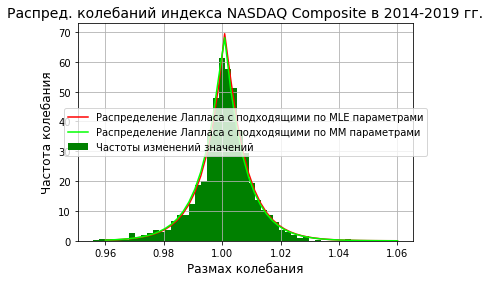

In [493]:
fluctuating_index_distribution(NASDAQ)

In [541]:
quantile_table(NASDAQ)

,Порядок alpha,Значение квантиля
0,0.01,0.969669
1,0.02,0.974874
2,0.03,0.978231
3,0.04,0.980985
4,0.05,0.983511
5,0.06,0.984600
6,0.07,0.985713
7,0.08,0.987274
8,0.09,0.988283
9,0.10,0.988934


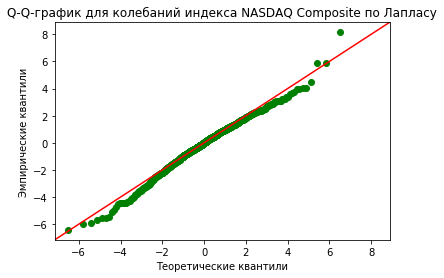

In [418]:
QQ_plot(NASDAQ)

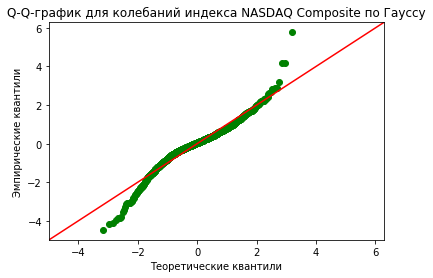

In [419]:
QQ_plot_N(NASDAQ)

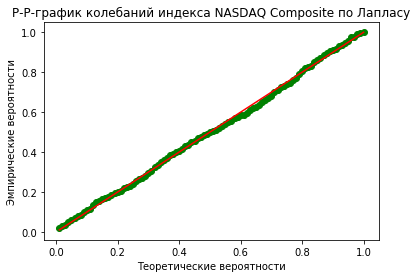

In [447]:
PP_plot(NASDAQ)

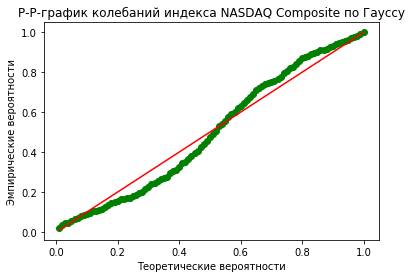

In [448]:
PP_plot_N(NASDAQ)

In [612]:
loss_gain_probs(NASDAQ)

Следующий скачок вверх <=  6.1 %
Следующий скачок вниз >= 5.9 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.214064,0.717697
1,1.0,0.105245,0.861205
2,1.5,0.051744,0.931761
3,2.0,0.025440,0.966450
4,2.5,0.012508,0.983505
5,3.0,0.006149,0.991890
6,3.5,0.003023,0.996013
7,4.0,0.001486,0.998040
8,4.5,0.000731,0.999036


### 3. Индекс Standard & Poor's 500 (S&P 500)

In [290]:
SP500 = processing_data(pd.read_csv('Stepenko_S&P_500.csv'))

Объем выборки: 1340
Максимальное значение выборки:  2943.030029
Минимальное значение выборки:  1741.890015


In [291]:
SP500

,Date,Close,CloseMove,LagRatio
1,2014-01-02,1831.979980,1848.359985,0.991138
2,2014-01-03,1831.369995,1831.979980,0.999667
3,2014-01-06,1826.770020,1831.369995,0.997488
4,2014-01-07,1837.880005,1826.770020,1.006082
5,2014-01-08,1837.489990,1837.880005,0.999788
6,2014-01-09,1838.130005,1837.489990,1.000348
7,2014-01-10,1842.369995,1838.130005,1.002307
8,2014-01-13,1819.199951,1842.369995,0.987424
9,2014-01-14,1838.880005,1819.199951,1.010818
10,2014-01-15,1848.380005,1838.880005,1.005166


In [292]:
SP500['Index Name'] = "S&P 500"
SP500['Plot Color'] = 'orange'

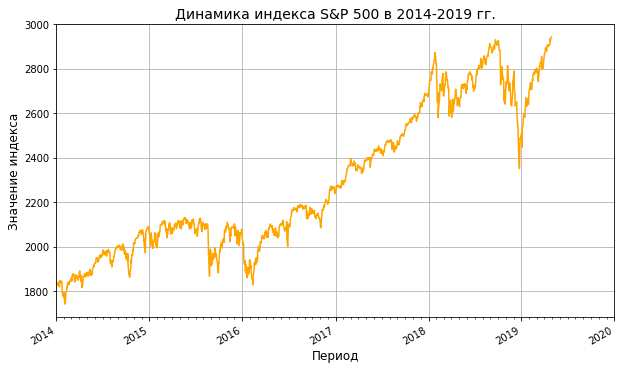

In [422]:
series_standart_plot(SP500)

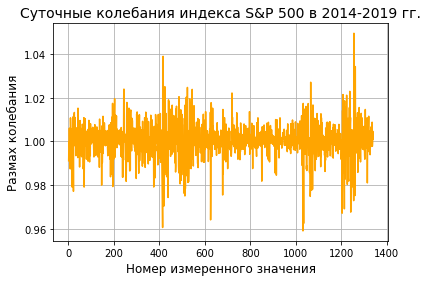

In [423]:
lag_ratio_plot(SP500)

In [295]:
SP500 = MLE_laplace_estimators(SP500)

In [296]:
SP500 = MM_laplace_estimators(SP500)

In [297]:
goodness_of_fit_testing(SP500)


Наиболее подходящие распределения для колебаний индекса S&P 500 :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
9        laplace     44.808075          0.11270
11    loglaplace     45.282366          0.11611
13             t     62.225734          0.07102
1         cauchy    113.660815          0.00512
6    genlogistic    186.337827          0.00015
12      logistic    206.394834          0.00012
10     johnsonsb    605.330188          0.00000
5       gengamma    612.823407          0.00000
0           beta    617.990955          0.00000
8           norm    670.024630          0.00000
7        lognorm    720.779428          0.00000
4          gamma    858.381089          0.00000
14   weibull_min   1093.139235          0.00000
15   weibull_max  15331.254828          0.00000
3           chi2  21667.238655          0.00000
2            chi  70085.342913          0.00000
___________________________________________________
P-значение для

Оценка по методу максимального правдоподобия: a = 1.000492; b = 0.005693
Оценка по методу моментов: a = 1.000389; b = 0.005869


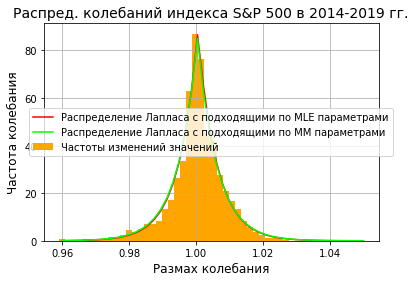

In [494]:
fluctuating_index_distribution(SP500)

In [542]:
quantile_table(SP500)

,Порядок alpha,Значение квантиля
0,0.01,0.975332
1,0.02,0.979204
2,0.03,0.981856
3,0.04,0.984298
4,0.05,0.985823
5,0.06,0.987088
6,0.07,0.988392
7,0.08,0.989721
8,0.09,0.990658
9,0.10,0.991399


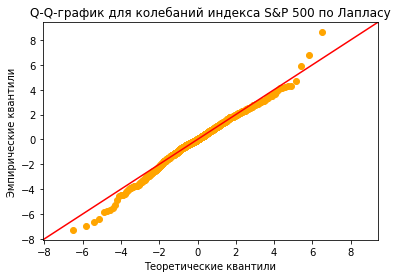

In [425]:
QQ_plot(SP500)

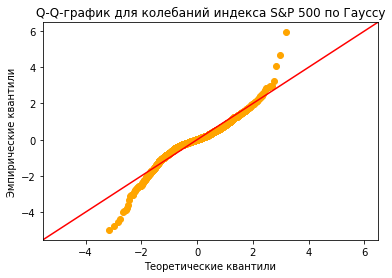

In [426]:
QQ_plot_N(SP500)

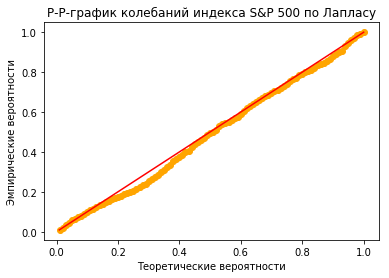

In [449]:
PP_plot(SP500)

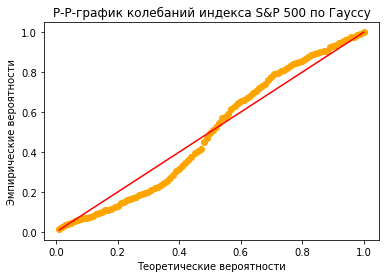

In [450]:
PP_plot_N(SP500)

In [613]:
loss_gain_probs(SP500)

Следующий скачок вверх <=  4.9 %
Следующий скачок вниз >= 4.8 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.190538,0.773490
1,1.0,0.079168,0.905886
2,1.5,0.032894,0.960896
3,2.0,0.013667,0.983753
4,2.5,0.005679,0.993249
5,3.0,0.002359,0.997195
6,3.5,0.000980,0.998835
7,4.0,0.000407,0.999516
8,4.5,0.000169,0.999799


### 4. Индекс Deutscher Aktienindex (DAX, GER30)

In [303]:
DAX = processing_data(pd.read_csv('Stepenko_DAX.csv'))

Объем выборки: 1135
Максимальное значение выборки:  33.799999
Минимальное значение выборки:  21.462999


In [304]:
DAX

,Date,Close,CloseMove,LagRatio
1,2014-10-24,25.190001,25.250000,0.997624
2,2014-10-27,25.028000,25.190001,0.993569
3,2014-10-28,25.510000,25.028000,1.019258
4,2014-10-29,25.670000,25.510000,1.006272
5,2014-10-30,25.389999,25.670000,0.989092
6,2014-10-31,25.750000,25.389999,1.014179
7,2014-11-03,26.049999,25.750000,1.011650
8,2014-11-04,25.500000,26.049999,0.978887
9,2014-11-05,25.639999,25.500000,1.005490
10,2014-11-06,25.559999,25.639999,0.996880


In [305]:
DAX['Index Name'] = "DAX"
DAX['Plot Color'] = 'black'

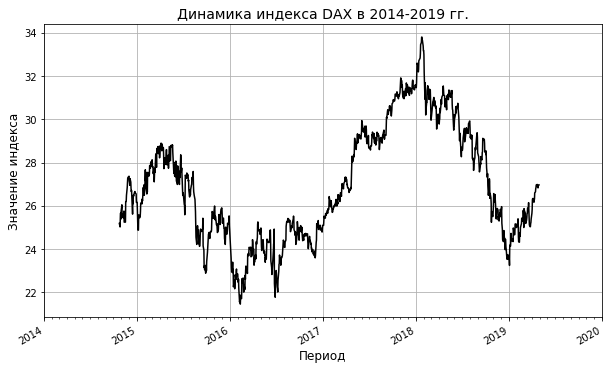

In [429]:
series_standart_plot(DAX)

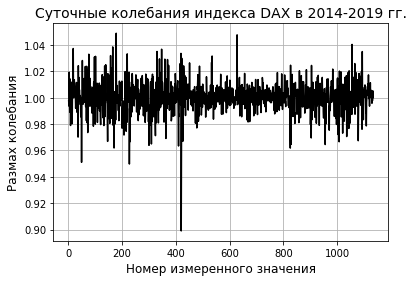

In [430]:
lag_ratio_plot(DAX)

In [308]:
DAX = MLE_laplace_estimators(DAX)

In [309]:
DAX = MM_laplace_estimators(DAX)

In [310]:
goodness_of_fit_testing(DAX)


Наиболее подходящие распределения для колебаний индекса DAX :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
13             t     12.287710          0.75925
11    loglaplace     22.706364          0.15250
9        laplace     23.517020          0.15255
6    genlogistic     40.580176          0.26788
12      logistic     44.903709          0.33437
1         cauchy    147.980872          0.00254
10     johnsonsb    245.512311          0.00026
0           beta    247.085394          0.00028
5       gengamma    247.837354          0.00028
8           norm    278.462227          0.00007
7        lognorm    283.795220          0.00006
15   weibull_max    673.850309          0.00000
14   weibull_min    788.746263          0.00000
3           chi2    791.709811          0.00000
2            chi  18532.039999          0.00000
4          gamma  19024.865399          0.00000
___________________________________________________
P-значение для рас

Оценка по методу максимального правдоподобия: a = 1.0; b = 0.008378
Оценка по методу моментов: a = 1.00013; b = 0.008352


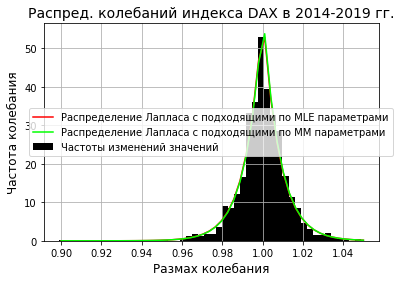

In [495]:
fluctuating_index_distribution(DAX)

In [543]:
quantile_table(DAX)

,Порядок alpha,Значение квантиля
0,0.01,0.966630
1,0.02,0.972691
2,0.03,0.978572
3,0.04,0.980161
4,0.05,0.981208
5,0.06,0.982176
6,0.07,0.983725
7,0.08,0.985336
8,0.09,0.985843
9,0.10,0.986686


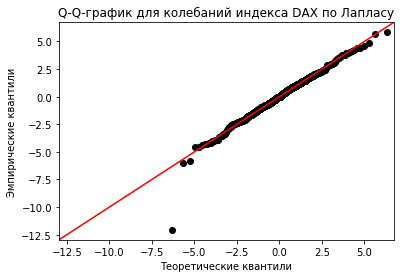

In [432]:
QQ_plot(DAX)

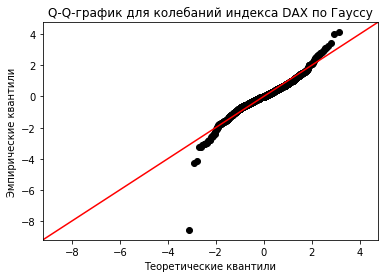

In [433]:
QQ_plot_N(DAX)

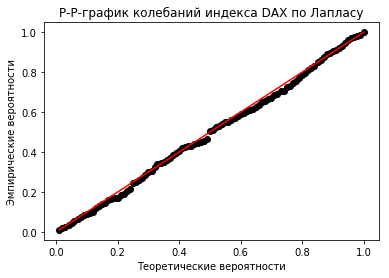

In [451]:
PP_plot(DAX)

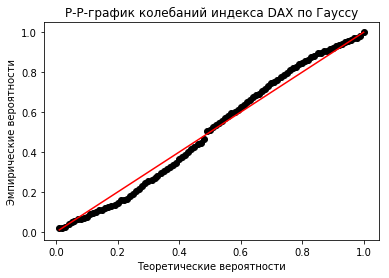

In [452]:
PP_plot_N(DAX)

In [614]:
loss_gain_probs(DAX)

Следующий скачок вверх <=  7.14 %
Следующий скачок вниз >= 7.14 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.275289,0.724709
1,1.0,0.151568,0.848431
2,1.5,0.083450,0.916549
3,2.0,0.045946,0.954054
4,2.5,0.025297,0.974703
5,3.0,0.013928,0.986072
6,3.5,0.007668,0.992332
7,4.0,0.004222,0.995778
8,4.5,0.002325,0.997675


### 5. Индекс МосБиржи (ММВБ, MOEX)

In [316]:
MB = processing_data(pd.read_csv('Stepenko_MOEX.csv'))

Объем выборки: 1334
Максимальное значение выборки:  138.5
Минимальное значение выборки:  49.130001


In [317]:
MB

,Date,Close,CloseMove,LagRatio
1,2014-01-08,65.000000,62.919998,1.033058
2,2014-01-09,65.070000,65.000000,1.001077
3,2014-01-10,65.300003,65.070000,1.003535
4,2014-01-13,65.199997,65.300003,0.998469
5,2014-01-14,64.809998,65.199997,0.994018
6,2014-01-15,65.000000,64.809998,1.002932
7,2014-01-16,64.699997,65.000000,0.995385
8,2014-01-17,64.500000,64.699997,0.996909
9,2014-01-20,63.660000,64.500000,0.986977
10,2014-01-21,64.199997,63.660000,1.008483


In [318]:
MB['Index Name'] = "Мосбиржи"
MB['Plot Color'] = 'purple'

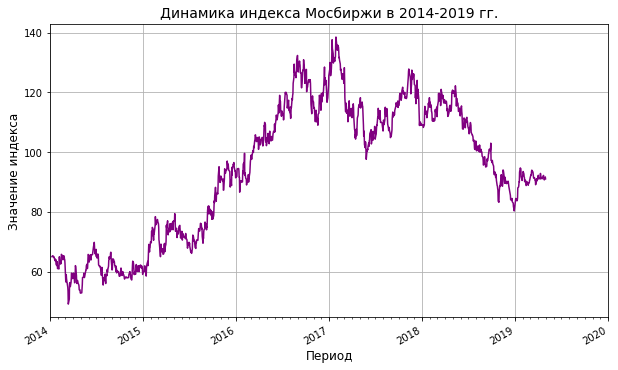

In [436]:
series_standart_plot(MB)

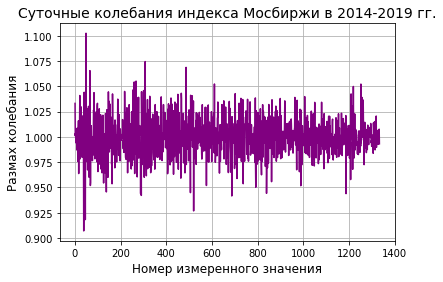

In [437]:
lag_ratio_plot(MB)

In [321]:
MB = MLE_laplace_estimators(MB)

In [322]:
MB = MM_laplace_estimators(MB)

In [323]:
goodness_of_fit_testing(MB)


Наиболее подходящие распределения для колебаний индекса Мосбиржи :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
13             t     21.540167          0.13548
11    loglaplace     24.742745          0.09573
6    genlogistic     28.087360          0.10853
9        laplace     28.171828          0.08711
12      logistic     28.228722          0.09326
10     johnsonsb    140.472572          0.00409
8           norm    140.693121          0.00408
0           beta    140.762299          0.00410
4          gamma    141.542537          0.00537
7        lognorm    141.744244          0.00580
5       gengamma    145.315027          0.00510
1         cauchy    188.250877          0.00021
3           chi2    284.362231          0.00001
14   weibull_min    525.599219          0.00001
15   weibull_max  14283.409880          0.00000
2            chi  15477.232063          0.00000
___________________________________________________
P-значение дл

Оценка по методу максимального правдоподобия: a = 0.999905; b = 0.013732
Оценка по методу моментов: a = 1.000425; b = 0.013116


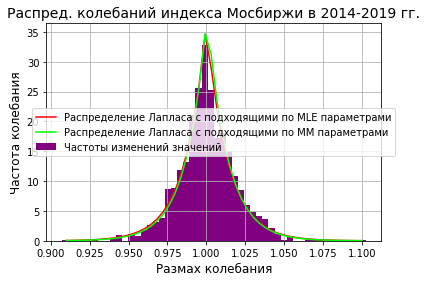

In [496]:
fluctuating_index_distribution(MB)

In [544]:
quantile_table(MB)

,Порядок alpha,Значение квантиля
0,0.01,0.952394
1,0.02,0.961034
2,0.03,0.964626
3,0.04,0.968260
4,0.05,0.971838
5,0.06,0.973470
6,0.07,0.975239
7,0.08,0.976103
8,0.09,0.977138
9,0.10,0.978264


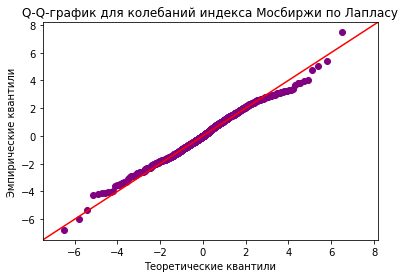

In [439]:
QQ_plot(MB)

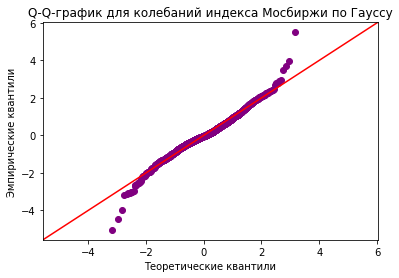

In [440]:
QQ_plot_N(MB)

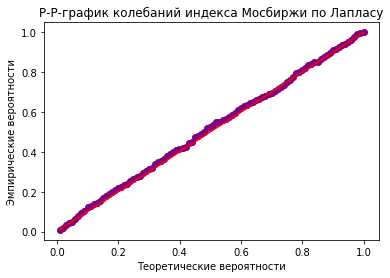

In [453]:
PP_plot(MB)

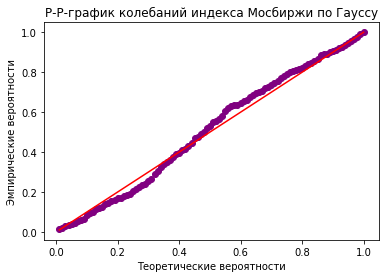

In [454]:
PP_plot_N(MB)

In [615]:
loss_gain_probs(MB)

Следующий скачок вверх <=  11.69 %
Следующий скачок вниз >= 11.7 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.349825,0.655004
1,1.0,0.243059,0.760296
2,1.5,0.168879,0.833453
3,2.0,0.117337,0.884282
4,2.5,0.081526,0.919599
5,3.0,0.056645,0.944137
6,3.5,0.039357,0.961186
7,4.0,0.027345,0.973032
8,4.5,0.019000,0.981263


### 6. Индекс Russell 2000

In [329]:
RUSSELL = processing_data(pd.read_csv('Stepenko_Russell_2000.csv'))

Объем выборки: 1340
Максимальное значение выборки:  1740.75
Минимальное значение выборки:  953.7199710000001


In [330]:
RUSSELL

,Date,Close,CloseMove,LagRatio
1,2014-01-02,1150.719971,1163.640015,0.988897
2,2014-01-03,1156.089966,1150.719971,1.004667
3,2014-01-06,1147.160034,1156.089966,0.992276
4,2014-01-07,1157.630005,1147.160034,1.009127
5,2014-01-08,1157.459961,1157.630005,0.999853
6,2014-01-09,1158.349976,1157.459961,1.000769
7,2014-01-10,1164.530029,1158.349976,1.005335
8,2014-01-13,1148.089966,1164.530029,0.985883
9,2014-01-14,1163.430054,1148.089966,1.013361
10,2014-01-15,1171.349976,1163.430054,1.006807


In [331]:
RUSSELL['Index Name'] = "Russell 2000"
RUSSELL['Plot Color'] = 'yellow'

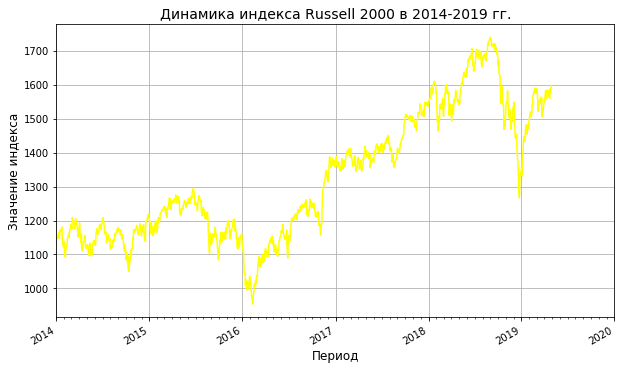

In [455]:
series_standart_plot(RUSSELL)

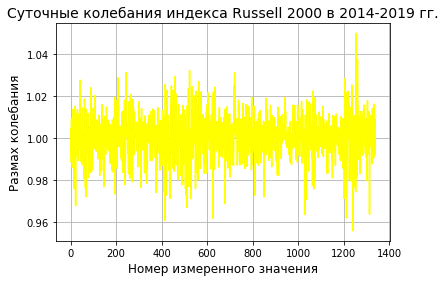

In [456]:
lag_ratio_plot(RUSSELL)

In [334]:
RUSSELL = MLE_laplace_estimators(RUSSELL)

In [335]:
RUSSELL = MM_laplace_estimators(RUSSELL)

In [336]:
goodness_of_fit_testing(RUSSELL)


Наиболее подходящие распределения для колебаний индекса Russell 2000 :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
6    genlogistic      7.111256          0.94332
12      logistic     38.114315          0.64164
9        laplace     78.550924          0.10727
11    loglaplace     80.619788          0.10264
10     johnsonsb     93.444884          0.01048
13             t    131.196347          0.00253
8           norm    135.804438          0.00199
7        lognorm    141.934418          0.00192
0           beta    142.185770          0.00125
4          gamma    166.282725          0.00074
2            chi    264.677506          0.00001
1         cauchy    468.422195          0.00001
14   weibull_min   8590.935005          0.00000
15   weibull_max  14090.856506          0.00000
5       gengamma  20173.994048          0.00000
3           chi2  26921.870362          0.00000
___________________________________________________
P-значени

Оценка по методу максимального правдоподобия: a = 1.0009; b = 0.007776
Оценка по методу моментов: a = 1.000299; b = 0.007305


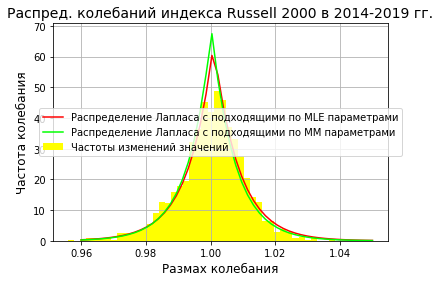

In [497]:
fluctuating_index_distribution(RUSSELL)

In [545]:
quantile_table(RUSSELL)

,Порядок alpha,Значение квантиля
0,0.01,0.971658
1,0.02,0.976389
2,0.03,0.979706
3,0.04,0.981065
4,0.05,0.982779
5,0.06,0.983807
6,0.07,0.984837
7,0.08,0.985553
8,0.09,0.986388
9,0.10,0.987251


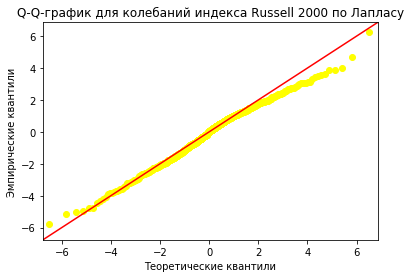

In [458]:
QQ_plot(RUSSELL)

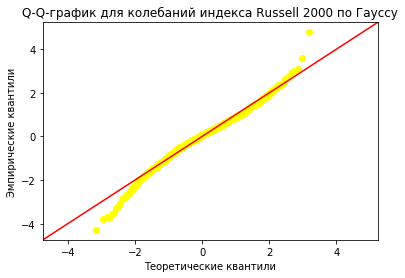

In [459]:
QQ_plot_N(RUSSELL)

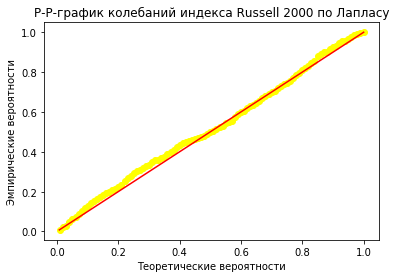

In [460]:
PP_plot(RUSSELL)

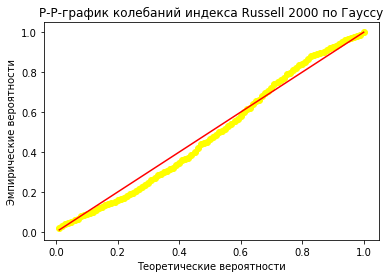

In [461]:
PP_plot_N(RUSSELL)

In [616]:
loss_gain_probs(RUSSELL)

Следующий скачок вверх <=  6.71 %
Следующий скачок вниз >= 6.53 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.234128,0.704886
1,1.0,0.123085,0.844854
2,1.5,0.064708,0.918437
3,2.0,0.034018,0.957121
4,2.5,0.017884,0.977458
5,3.0,0.009402,0.988149
6,3.5,0.004943,0.993770
7,4.0,0.002598,0.996725
8,4.5,0.001366,0.998278


### 7. Индекс Nikkei 225

In [342]:
NIK = processing_data(pd.read_csv('Stepenko_Nikkei_225.csv'))

Объем выборки: 1305
Максимальное значение выборки:  24270.619141
Минимальное значение выборки:  13910.160156


In [343]:
NIK

,Date,Close,CloseMove,LagRatio
1,2014-01-07,15814.370117,15908.879883,0.994059
2,2014-01-08,16121.450195,15814.370117,1.019418
3,2014-01-09,15880.330078,16121.450195,0.985044
4,2014-01-10,15912.059570,15880.330078,1.001998
5,2014-01-14,15422.400391,15912.059570,0.969227
6,2014-01-15,15808.730469,15422.400391,1.025050
7,2014-01-16,15747.200195,15808.730469,0.996108
8,2014-01-17,15734.459961,15747.200195,0.999191
9,2014-01-20,15641.679688,15734.459961,0.994103
10,2014-01-21,15795.959961,15641.679688,1.009863


In [344]:
NIK['Index Name'] = "Nikkei 225"
NIK['Plot Color'] = 'grey'

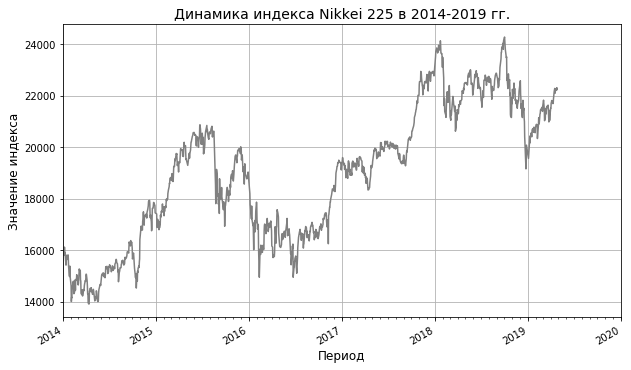

In [462]:
series_standart_plot(NIK)

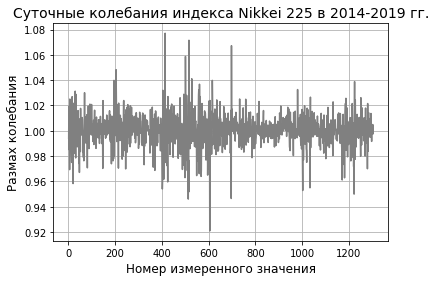

In [463]:
lag_ratio_plot(NIK)

In [347]:
NIK = MLE_laplace_estimators(NIK)

In [348]:
NIK = MM_laplace_estimators(NIK)

In [349]:
goodness_of_fit_testing(NIK)


Наиболее подходящие распределения для колебаний индекса Nikkei 225 :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
9        laplace     12.647391          0.46263
11    loglaplace     12.751063          0.47103
13             t     29.923193          0.81731
6    genlogistic     86.718369          0.01782
12      logistic    110.563808          0.00881
1         cauchy    163.133112          0.00161
5       gengamma    476.448260          0.00000
0           beta    498.287943          0.00000
10     johnsonsb    500.864225          0.00000
8           norm    508.712386          0.00000
7        lognorm    527.689839          0.00000
4          gamma    558.122747          0.00000
3           chi2    658.051410          0.00000
14   weibull_min   1390.497604          0.00000
15   weibull_max  13186.460288          0.00000
2            chi  30497.751428          0.00000
___________________________________________________
P-значение 

Оценка по методу максимального правдоподобия: a = 1.000718; b = 0.008805
Оценка по методу моментов: a = 1.000344; b = 0.009015


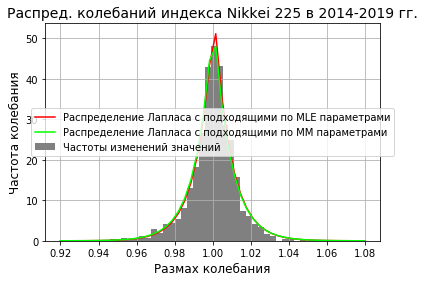

In [498]:
fluctuating_index_distribution(NIK)

In [546]:
quantile_table(NIK)

,Порядок alpha,Значение квантиля
0,0.01,0.962775
1,0.02,0.969820
2,0.03,0.973892
3,0.04,0.976528
4,0.05,0.978841
5,0.06,0.980403
6,0.07,0.982439
7,0.08,0.984266
8,0.09,0.985655
9,0.10,0.986593


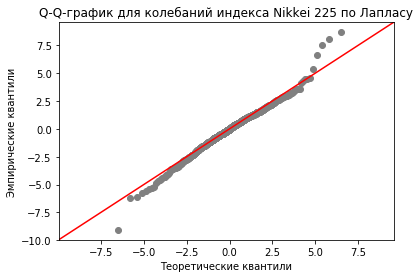

In [469]:
QQ_plot(NIK)

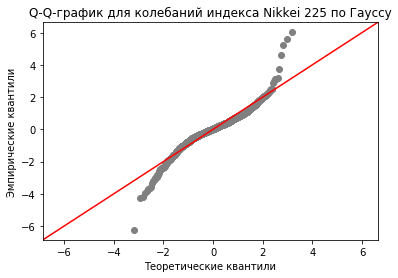

In [466]:
QQ_plot_N(NIK)

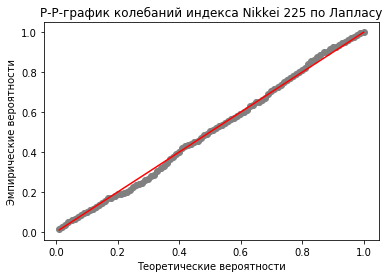

In [467]:
PP_plot(NIK)

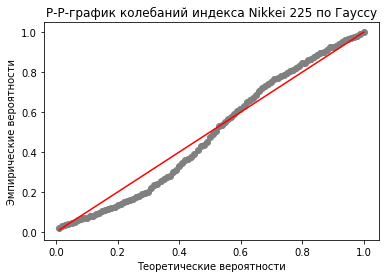

In [468]:
PP_plot_N(NIK)

In [618]:
loss_gain_probs(NIK)

Следующий скачок вверх <=  7.57 %
Следующий скачок вниз >= 7.43 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.261197,0.692561
1,1.0,0.148034,0.825758
2,1.5,0.083899,0.901248
3,2.0,0.047550,0.944032
4,2.5,0.026949,0.968280
5,3.0,0.015273,0.982023
6,3.5,0.008656,0.989811
7,4.0,0.004906,0.994225
8,4.5,0.002780,0.996727


### 8. Индекс Hang Seng

In [355]:
HANGS = processing_data(pd.read_csv('Stepenko_HangSeng.csv'))

Объем выборки: 1310
Максимальное значение выборки:  33154.121094
Минимальное значение выборки:  18319.580078


In [356]:
HANGS

,Date,Close,CloseMove,LagRatio
1,2014-01-03,22817.279297,23340.050781,0.977602
2,2014-01-06,22684.150391,22817.279297,0.994165
3,2014-01-07,22712.779297,22684.150391,1.001262
4,2014-01-08,22996.589844,22712.779297,1.012496
5,2014-01-09,22787.330078,22996.589844,0.990900
6,2014-01-10,22846.250000,22787.330078,1.002586
7,2014-01-13,22888.759766,22846.250000,1.001861
8,2014-01-14,22791.279297,22888.759766,0.995741
9,2014-01-15,22902.000000,22791.279297,1.004858
10,2014-01-16,22986.410156,22902.000000,1.003686


In [357]:
HANGS['Index Name'] = "Hang Seng"
HANGS['Plot Color'] = 'cyan'

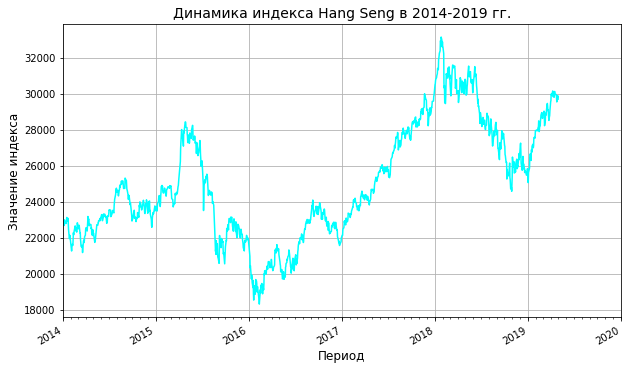

In [470]:
series_standart_plot(HANGS)

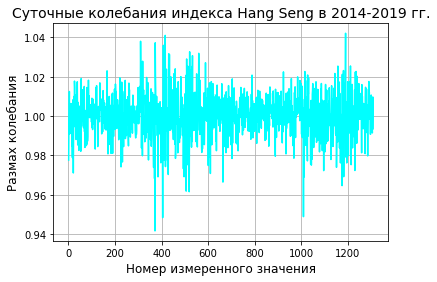

In [471]:
lag_ratio_plot(HANGS)

In [360]:
HANGS = MLE_laplace_estimators(HANGS)

In [361]:
HANGS = MM_laplace_estimators(HANGS)

In [362]:
goodness_of_fit_testing(HANGS)


Наиболее подходящие распределения для колебаний индекса Hang Seng :
__________________________________________________
   Распределение    Хи-квадрат  P-значение(MLE)
6    genlogistic     12.030155          0.51892
12      logistic     27.503234          0.35343
11    loglaplace     38.512142          0.34451
9        laplace     38.635360          0.34262
10     johnsonsb    133.667350          0.00250
13             t    152.772108          0.00055
8           norm    160.132831          0.00042
7        lognorm    169.675643          0.00023
5       gengamma    178.821252          0.00013
4          gamma    199.157120          0.00008
3           chi2    279.733170          0.00000
1         cauchy    308.081643          0.00009
14   weibull_min    354.553966          0.00001
15   weibull_max  10449.429778          0.00000
0           beta  31617.684502          0.00000
2            chi  57825.432674          0.00000
___________________________________________________
P-значение д

Оценка по методу максимального правдоподобия: a = 1.000675; b = 0.008003
Оценка по методу моментов: a = 1.00026; b = 0.00766


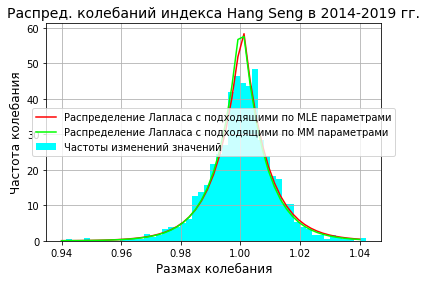

In [499]:
fluctuating_index_distribution(HANGS)

In [547]:
quantile_table(HANGS)

,Порядок alpha,Значение квантиля
0,0.01,0.970827
1,0.02,0.975303
2,0.03,0.978166
3,0.04,0.980910
4,0.05,0.982337
5,0.06,0.983975
6,0.07,0.984849
7,0.08,0.985542
8,0.09,0.986346
9,0.10,0.987073


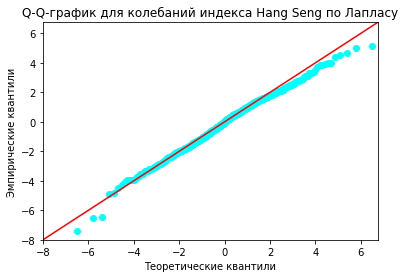

In [473]:
QQ_plot(HANGS)

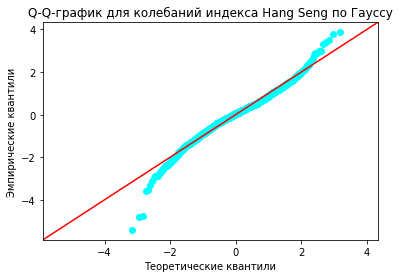

In [474]:
QQ_plot_N(HANGS)

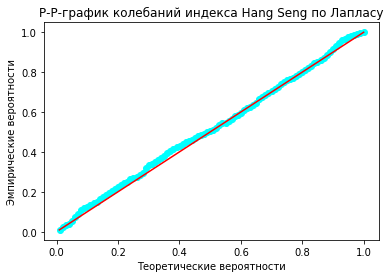

In [475]:
PP_plot(HANGS)

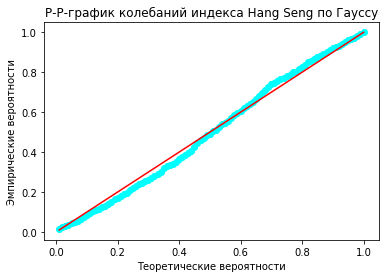

In [476]:
PP_plot_N(HANGS)

In [619]:
loss_gain_probs(HANGS)

Следующий скачок вверх <=  6.88 %
Следующий скачок вниз >= 6.75 %


,"Изменение x, %",Вероятность падения на x %,Вероятность роста на x %
0,0.5,0.246029,0.708737
1,1.0,0.131720,0.844062
2,1.5,0.070521,0.916513
3,2.0,0.037756,0.955303
4,2.5,0.020214,0.976070
5,3.0,0.010822,0.987188
6,3.5,0.005794,0.993141
7,4.0,0.003102,0.996328
8,4.5,0.001661,0.998034
